<a href="https://colab.research.google.com/github/MMIJEONG/stock_prediction/blob/main/Untitled31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
stocks =  pd.read_csv('/content/sample_data/삼성전자.csv', header=0)
stocks

,날짜,시가,고가,저가,종가,거래량
0,20210428,83200,83200,82100,82100,15255555
1,20210427,83200,83300,82500,82900,12941533
2,20210426,82900,83500,82600,83500,15489938
3,20210423,81900,82900,81600,82800,17805080
4,20210422,82900,83000,82400,82400,13934746
...,...,...,...,...,...,...
6237,19960629,68100,69100,67100,68500,96710
6238,19960628,67300,68500,67200,68100,138430
6239,19960627,67500,67700,66700,66900,155450
6240,19960626,67600,67900,66000,67700,136630


In [6]:
stocks['날짜'] = pd.to_datetime(stocks['날짜'], format='%Y%m%d')
# stocks['일자'] = pd.to_datetime(stocks['일자'], format='%Y-%m-%d')
stocks['연도'] = stocks['날짜'].dt.year

In [7]:
df = stocks.loc[stocks['날짜']>="1990"]

Text(0, 0.5, 'price')

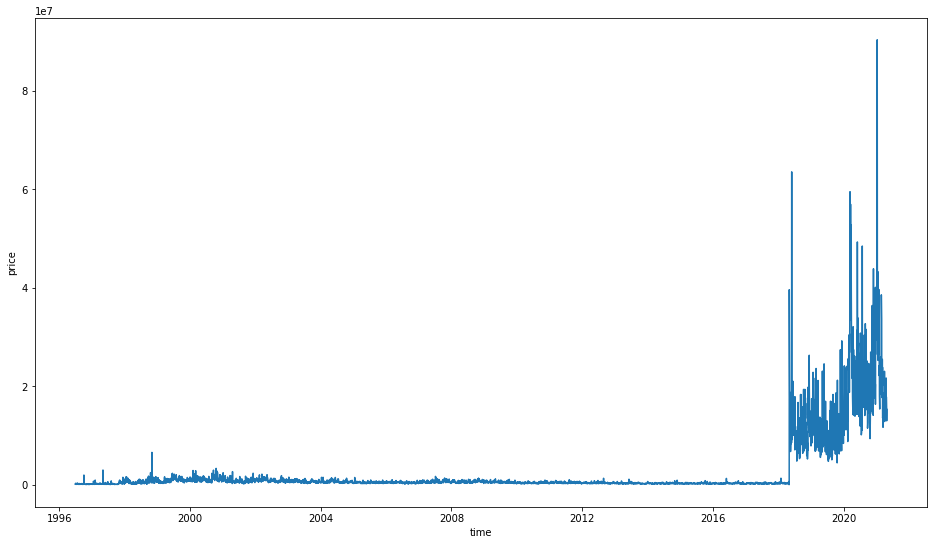

In [8]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['거래량'], x=df['날짜'])
plt.xlabel('time')
plt.ylabel('price')

Text(0, 0.5, 'price')

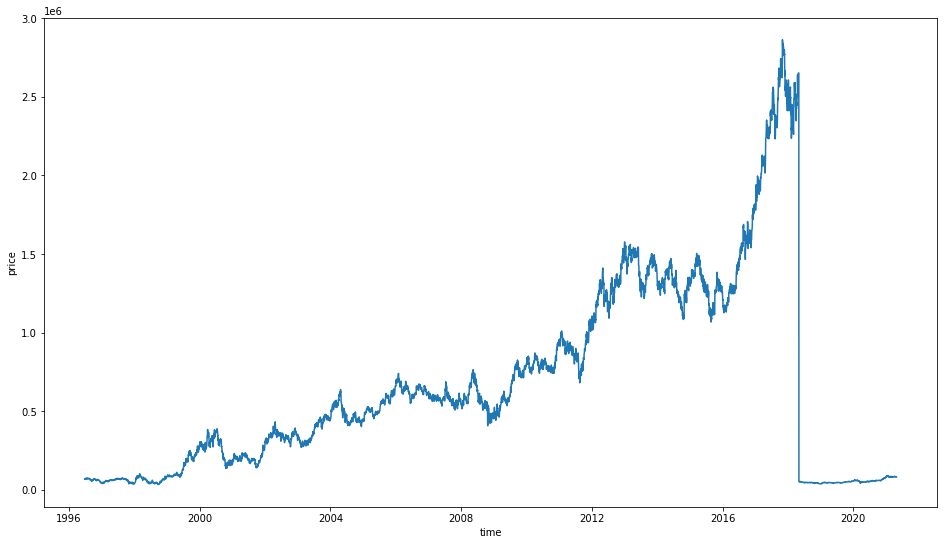

In [9]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['날짜'])
plt.xlabel('time')
plt.ylabel('price')

In [10]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,시가,고가,저가,종가,거래량
0,0.028939,0.028929,0.028929,0.017258,0.168931
1,0.028939,0.028964,0.029070,0.017541,0.143307
2,0.028835,0.029033,0.029105,0.017753,0.171527
3,0.028487,0.028825,0.028753,0.017505,0.197163
4,0.028835,0.028860,0.029035,0.017364,0.154306
...,...,...,...,...,...
6237,0.023687,0.024026,0.023643,0.012448,0.001071
6238,0.023409,0.023818,0.023679,0.012307,0.001533
6239,0.023478,0.023540,0.023502,0.011882,0.001721
6240,0.023513,0.023609,0.023256,0.012165,0.001513


In [11]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((4817, 20, 4), (1205, 20, 4))

In [13]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [14]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [16]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
302/302 [==============================] - 4s 9ms/step - loss: 0.0059 - val_loss: 0.0010

Epoch 00001: val_loss improved from inf to 0.00100, saving model to model/tmp_checkpoint.h5
Epoch 2/200
302/302 [==============================] - 2s 7ms/step - loss: 9.9527e-04 - val_loss: 9.3734e-04

Epoch 00002: val_loss improved from 0.00100 to 0.00094, saving model to model/tmp_checkpoint.h5
Epoch 3/200
302/302 [==============================] - 2s 7ms/step - loss: 9.9083e-04 - val_loss: 8.8616e-04

Epoch 00003: val_loss improved from 0.00094 to 0.00089, saving model to model/tmp_checkpoint.h5
Epoch 4/200
302/302 [==============================] - 2s 7ms/step - loss: 7.1967e-04 - val_loss: 8.3569e-04

Epoch 00004: val_loss improved from 0.00089 to 0.00084, saving model to model/tmp_checkpoint.h5
Epoch 5/200
302/302 [==============================] - 2s 8ms/step - loss: 2.2847e-04 - val_loss: 8.4021e-04

Epoch 00005: val_loss did not improve from 0.00084
Epoch 6/200
302/302 [======

In [17]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(180, 1)

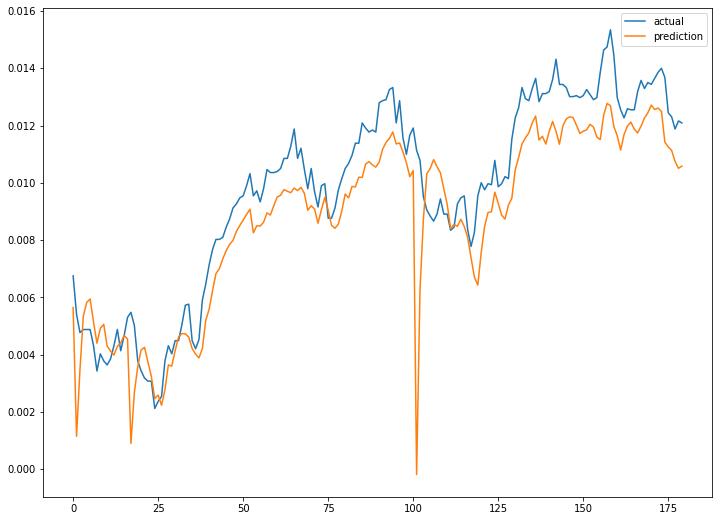

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()